# Analyse Exploratoire

### Import des modules

In [551]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from projet_3_struct.funcs import (
    Multi_usage,
    Categorie_anne_construction,
    Categorie_nb_etage,
    Categorie_nb_batiment,
    calcul_part_habitation,
)

from scipy import stats

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error ,mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Analyse Exploratoire

In [552]:
building_consumption = pd.read_csv("2016_Building_Energy_Benchmarking.csv")

In [553]:
# On regarde comment un batiment est défini dans ce jeu de données 
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [554]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [555]:
#Requalification des variables en quanti/quali

building_consumption["DataYear"] = building_consumption["DataYear"].astype("category")
building_consumption["OSEBuildingID"] = building_consumption["OSEBuildingID"].astype("object")
building_consumption["ZipCode"] = building_consumption["ZipCode"].astype("object")
building_consumption["CouncilDistrictCode"] = building_consumption["CouncilDistrictCode"].astype("object")
building_consumption["Comments"] = building_consumption["Comments"].astype("object")
building_consumption["DefaultData"] = building_consumption["DefaultData"].astype("object")

In [556]:
#Affichage des informations selon le type de variable qualitatives ou quantitaves

for col in building_consumption.columns:
    print(f"### Colonne : {col}\n")
        
    if building_consumption[col].dtype == "object" or str(building_consumption[col].dtype) == "category":
        print("Variable qualitative\n")
        print(building_consumption[col].value_counts(dropna=False))
    else:
        print("Variable quantitative\n")
        print(building_consumption[col].describe())
        
    print("\n" + "-"*50 + "\n")

### Colonne : OSEBuildingID

Variable qualitative

OSEBuildingID
1        1
2        1
3        1
5        1
8        1
        ..
50222    1
50223    1
50224    1
50225    1
50226    1
Name: count, Length: 3376, dtype: int64

--------------------------------------------------

### Colonne : DataYear

Variable qualitative

DataYear
2016    3376
Name: count, dtype: int64

--------------------------------------------------

### Colonne : BuildingType

Variable qualitative

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

--------------------------------------------------

### Colonne : PrimaryPropertyType

Variable qualitative

PrimaryPropertyType
Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other             

In [557]:
#Suppression des colonnes inutiles

del building_consumption['Comments']
del building_consumption['DataYear']
del building_consumption['TaxParcelIdentificationNumber']
del building_consumption['City']
del building_consumption['State']

In [558]:
#Nettoyage des données : renommage des données

building_consumption.loc[building_consumption['Neighborhood'] == "Northwest", 'Neighborhood'] = "NORTHWEST"
building_consumption.loc[building_consumption['Neighborhood'] == "North", 'Neighborhood'] = "NORTH"
building_consumption.loc[building_consumption['Neighborhood'] == "Central", 'Neighborhood'] = "CENTRAL"
building_consumption.loc[building_consumption['Neighborhood'] == "Ballard", 'Neighborhood'] = "BALLARD"
building_consumption.loc[building_consumption['Neighborhood'] == "Delridge", 'Neighborhood'] = "DELRIDGE"
building_consumption.loc[building_consumption['Neighborhood'] == "DELRIDGE NEIGHBORHOODS", 'Neighborhood'] = "DELRIDGE"
building_consumption.loc[building_consumption['BuildingType'] == "Nonresidential COS", 'BuildingType'] = "NonResidential"
building_consumption.loc[building_consumption['BuildingType'] == "Nonresidential WA", 'BuildingType'] = "NonResidential"

In [559]:
#suppression de valeurs aberrantes : remplacement par NaN

building_consumption.loc[building_consumption['NumberofFloors'] == 99, 'NumberofFloors'] = np.nan

In [560]:
building_consumption.loc[building_consumption[['PropertyName','Address']].duplicated(keep=False),:]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,...,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


In [561]:
#Creation de nouvelles features pour regrouper le mono et multi usage 

building_consumption["Usage_multiple"] = building_consumption.apply(Multi_usage, axis=1)

In [562]:
#Suppression des lignes des batiments uniquement famille

building_type_non_valide = ['Multifamily LR (1-4)','Multifamily MR (5-9)', 'Multifamily HR (10+)'] 
condition_suppression = (building_consumption['BuildingType'].isin(building_type_non_valide)) & (building_consumption['Usage_multiple'] == 'Mono usage')
building_consumption_filtré = building_consumption[~condition_suppression]
building_consumption_filtré = building_consumption_filtré[~(building_consumption_filtré['BuildingType'] == "Campus")]
print(f"Nombre de lignes restantes : {len(building_consumption_filtré)}")

building_consumption_filtré["BuildingType"].value_counts()

Nombre de lignes restantes : 2482


BuildingType
NonResidential          1546
Multifamily LR (1-4)     417
Multifamily MR (5-9)     345
SPS-District K-12         98
Multifamily HR (10+)      76
Name: count, dtype: int64

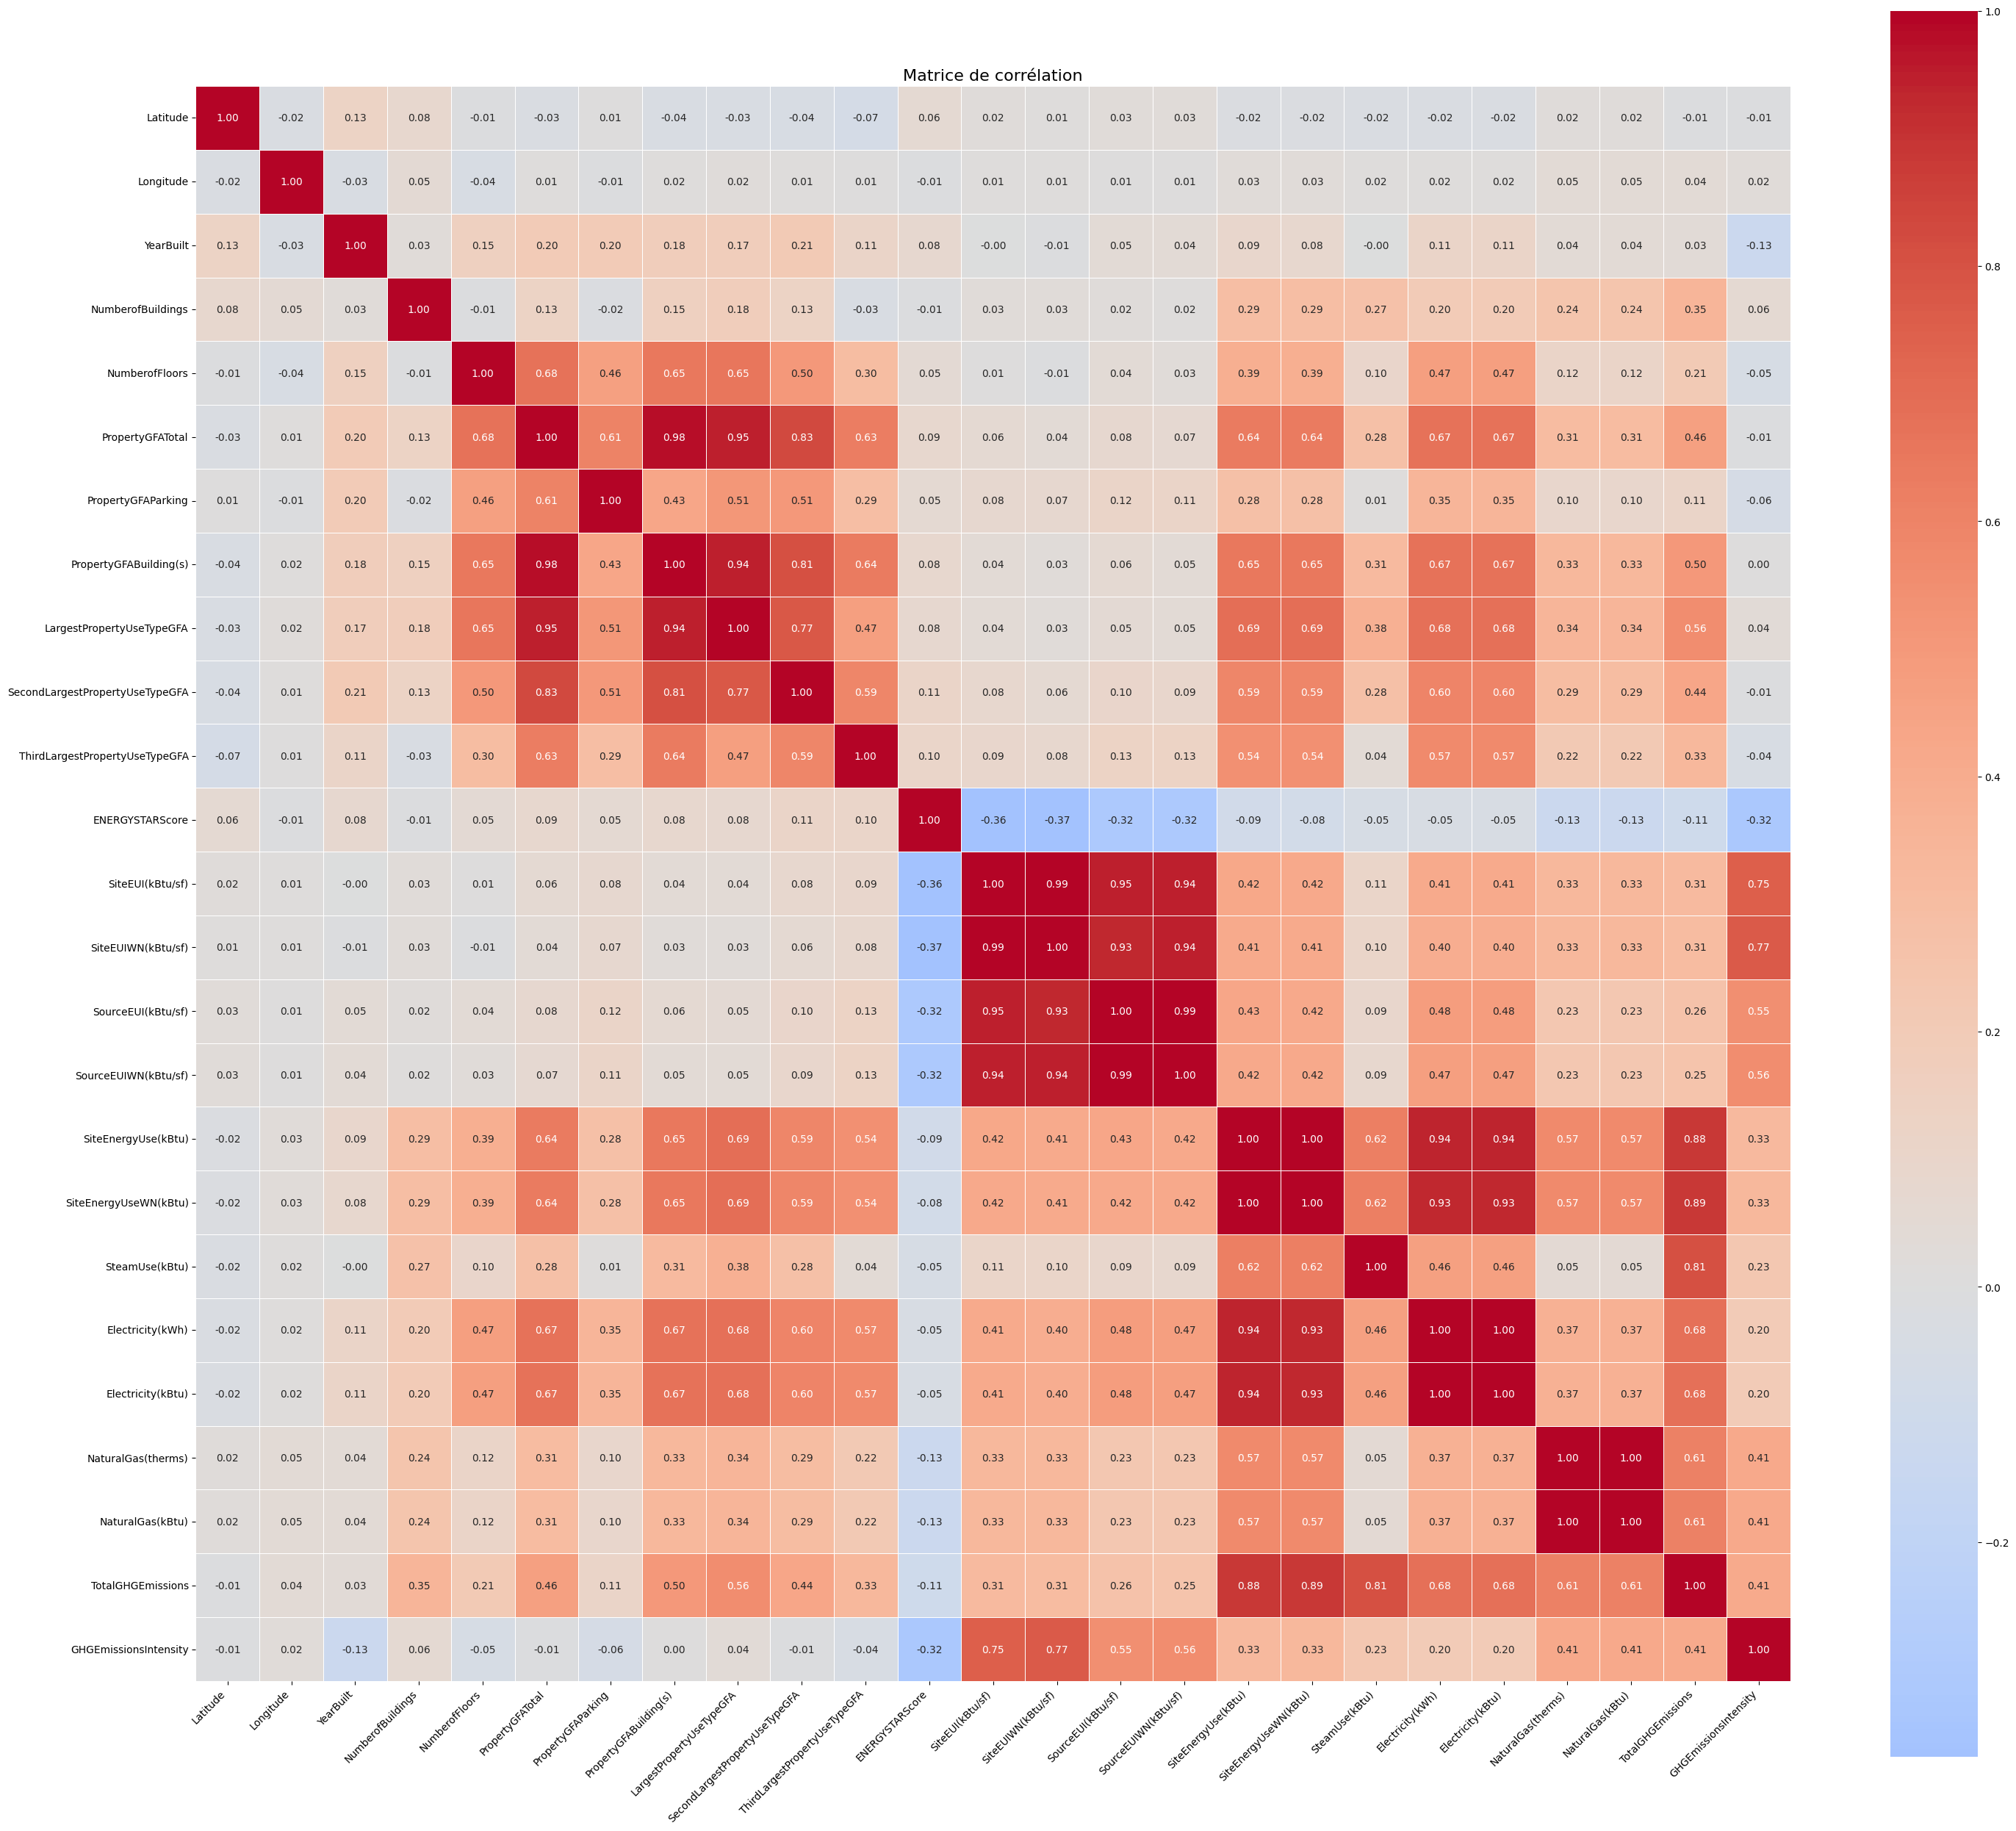

In [563]:
matrice_correlation_pearson = (
    building_consumption_filtré.corr(method='pearson', numeric_only=True)
)

plt.figure(figsize=(30, 30))

sns.heatmap(
    matrice_correlation_pearson,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title(
    "Matrice de corrélation",
    fontsize=16
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

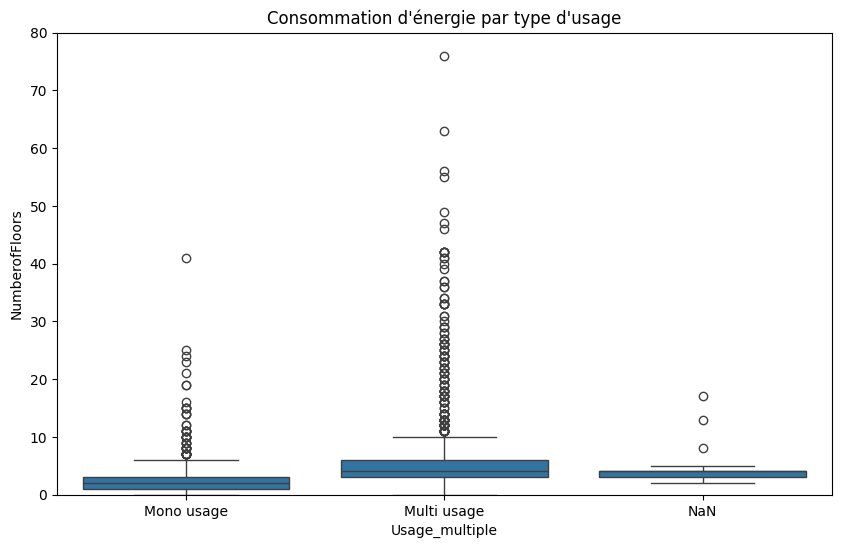

In [564]:
#Visualiation 1

plt.figure(figsize=(10, 6))
sns.boxplot(data=building_consumption_filtré, x="Usage_multiple", y="NumberofFloors")
plt.ylim(0, 80)
plt.title("Consommation d'énergie par type d'usage")
plt.show()

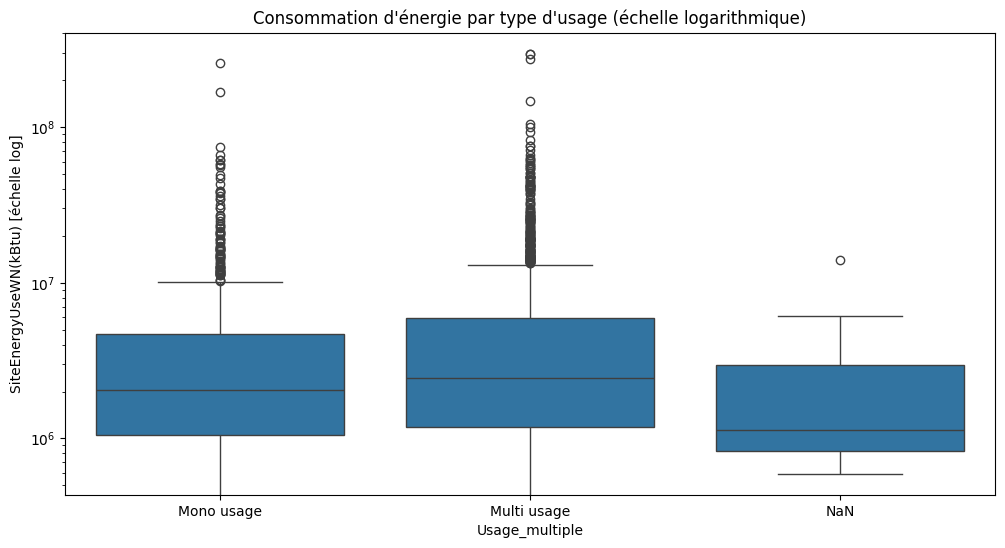

In [565]:
#Visualiation 2

plt.figure(figsize=(12, 6))
sns.boxplot(data=building_consumption_filtré, x="Usage_multiple", y="SiteEnergyUseWN(kBtu)")
plt.yscale("log")  
plt.title("Consommation d'énergie par type d'usage (échelle logarithmique)")
plt.ylabel("SiteEnergyUseWN(kBtu) [échelle log]")
plt.show()

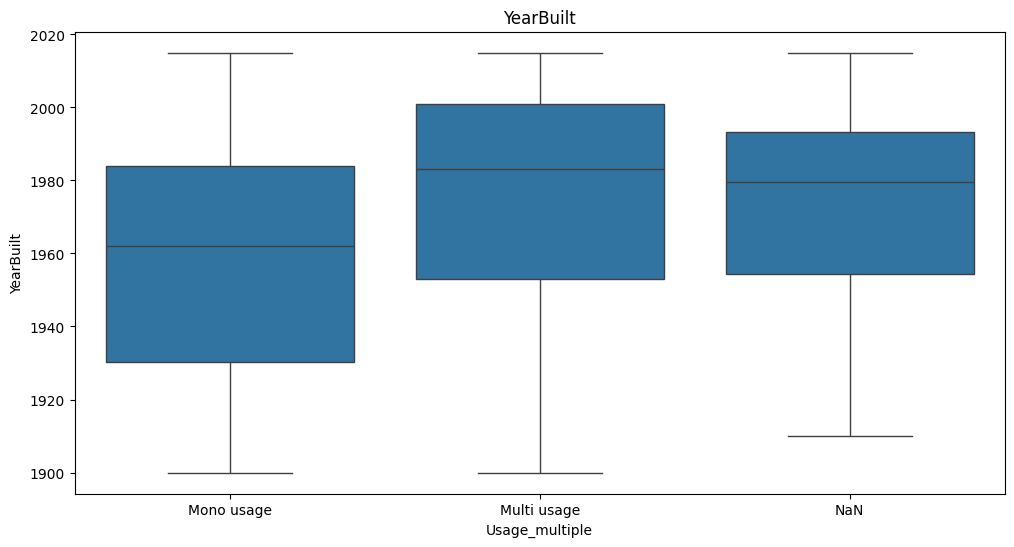

In [566]:
#Visualiation 3

plt.figure(figsize=(12, 6))
sns.boxplot(data=building_consumption_filtré, x="Usage_multiple", y="YearBuilt")
plt.title("YearBuilt")
plt.ylabel("YearBuilt")
plt.show()

In [567]:
#filtre sur les consommations pour enlever les 0
print(f"Nombre de lignes avant : {len(building_consumption_filtré)}")
building_consumption_filtré = building_consumption_filtré[building_consumption_filtré["SiteEnergyUse(kBtu)"] > 0]
building_consumption_filtré_V2_sans0_pour_C02 = building_consumption_filtré[building_consumption_filtré["TotalGHGEmissions"] > 0]
building_consumption_filtré.info()
print(f"Nombre de lignes restantes : {len(building_consumption_filtré)}")
print(f"Nombre de lignes restantes sans 0 de C02 : {len(building_consumption_filtré_V2_sans0_pour_C02)}")

Nombre de lignes avant : 2482
<class 'pandas.core.frame.DataFrame'>
Index: 2460 entries, 0 to 3375
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    2460 non-null   object 
 1   BuildingType                     2460 non-null   object 
 2   PrimaryPropertyType              2460 non-null   object 
 3   PropertyName                     2460 non-null   object 
 4   Address                          2460 non-null   object 
 5   ZipCode                          2444 non-null   object 
 6   CouncilDistrictCode              2460 non-null   object 
 7   Neighborhood                     2460 non-null   object 
 8   Latitude                         2460 non-null   float64
 9   Longitude                        2460 non-null   float64
 10  YearBuilt                        2460 non-null   int64  
 11  NumberofBuildings                2457 non-null   float64


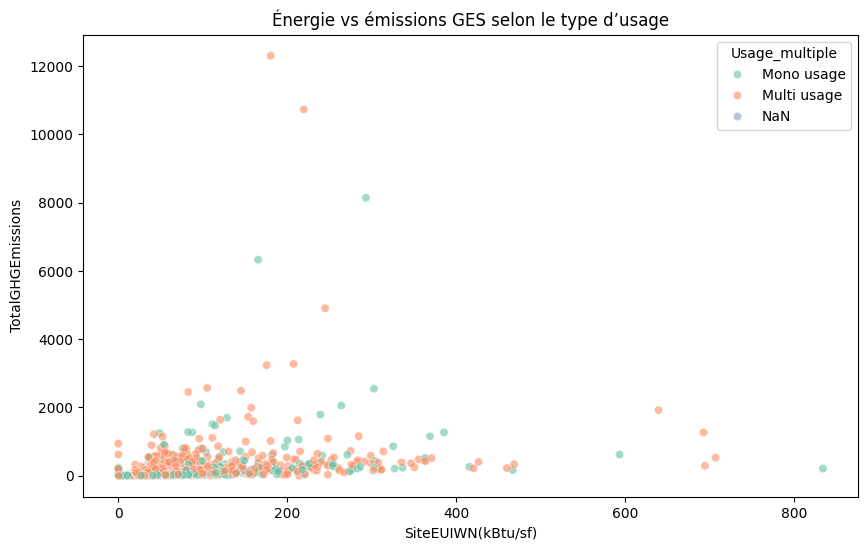

In [568]:
#Visualiation 4 Avec filtre sur les consommations pour enlever les 0

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=building_consumption_filtré,
    x="SiteEUIWN(kBtu/sf)",
    y="TotalGHGEmissions",
    hue="Usage_multiple",
    palette="Set2",
    alpha=0.6
)

plt.title("Énergie vs émissions GES selon le type d’usage")
plt.xlabel("SiteEUIWN(kBtu/sf)")
plt.ylabel("TotalGHGEmissions")
plt.show()

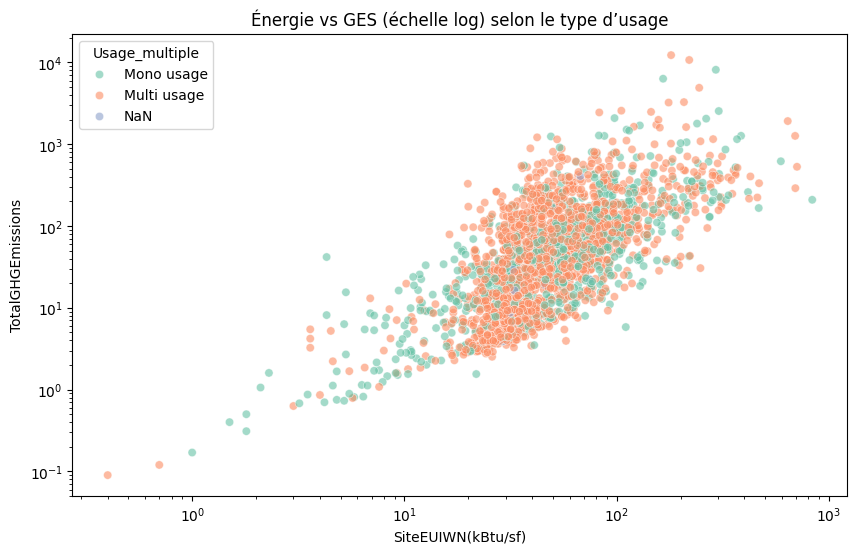

In [569]:
#Visualiation 5 Avec filtre sur les consommations pour enlever les 0

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=building_consumption_filtré,
    x="SiteEUIWN(kBtu/sf)",
    y="TotalGHGEmissions",
    hue="Usage_multiple",
    palette="Set2",
    alpha=0.6
)

plt.xscale("log")
plt.yscale("log")
plt.title("Énergie vs GES (échelle log) selon le type d’usage")
plt.xlabel("SiteEUIWN(kBtu/sf)")
plt.ylabel("TotalGHGEmissions")
plt.show()

C:\Users\thoma\AppData\Local\Temp\ipykernel_70680\549708490.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(building_consumption_filtré['SiteEUIWN(kBtu/sf)'])


<Axes: xlabel='SiteEUIWN(kBtu/sf)', ylabel='Density'>

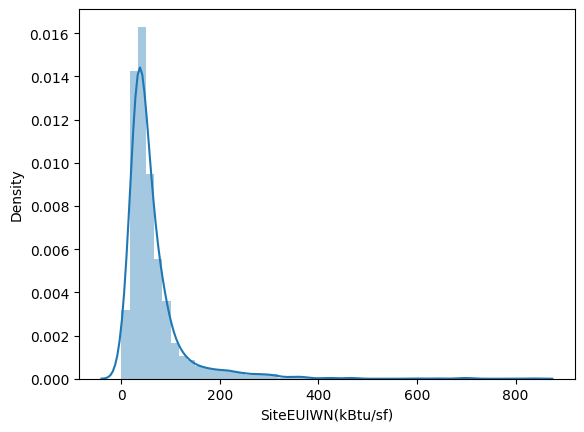

In [570]:
sns.distplot(building_consumption_filtré['SiteEUIWN(kBtu/sf)'])

# Modélisation 

### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

En règle générale : On utilise la méthode .apply() de Pandas pour créer une nouvelle colonne à partir d'une colonne existante. N'hésitez pas à regarder les exemples dans les chapitres de cours donnés en ressource

In [571]:
# CODE FEATURE ENGINEERING

# Création des colonnes booléennes
building_consumption_filtré['Conso_gaz_mesure'] = (building_consumption_filtré['NaturalGas(therms)'] != 0).astype(int)
building_consumption_filtré['Conso_elec_mesure'] = (building_consumption_filtré['Electricity(kWh)'] != 0).astype(int)
building_consumption_filtré['Emission_steam_mesure'] = (building_consumption_filtré['SteamUse(kBtu)'] != 0).astype(int)

In [572]:
#Creation de nouvelles features pour regrouper le mono et multi usage 

building_consumption_filtré["Usage_multiple"] = building_consumption_filtré.apply(Multi_usage, axis=1)
building_consumption_filtré["Usage_multiple"].value_counts()

Usage_multiple
Multi usage    1666
Mono usage      779
NaN              15
Name: count, dtype: int64

In [573]:
building_consumption_filtré['Groupe_anne_construction'] = building_consumption_filtré['YearBuilt'].apply(Categorie_anne_construction)
building_consumption_filtré["Groupe_anne_construction"].value_counts()

Groupe_anne_construction
1900-1974         1220
1975–1999          664
IECC 2000–2018     576
Name: count, dtype: int64

In [574]:
building_consumption_filtré['Groupe_nb_etages'] = building_consumption_filtré['NumberofFloors'].apply(Categorie_nb_etage)

building_consumption_filtré["Groupe_nb_etages"].value_counts()

Groupe_nb_etages
Bas      1662
Moyen     593
Haut      205
Name: count, dtype: int64

In [575]:
building_consumption_filtré['Groupe_nb_batiments'] = building_consumption_filtré['NumberofBuildings'].apply(Categorie_nb_batiment)

In [576]:

# 3) Application au DataFrame
building_consumption_filtré[["PartHabitation(%)", "PartNonHabitation(%)"]] = (
    building_consumption_filtré.apply(calcul_part_habitation, axis=1)
)

In [577]:
print(building_consumption_filtré["PartHabitation(%)"].describe())
print(building_consumption_filtré["PartNonHabitation(%)"].describe())

count    2445.000000
mean       26.359951
std        37.668912
min         0.000000
25%         0.000000
50%         0.000000
75%        69.470000
max       100.000000
Name: PartHabitation(%), dtype: float64
count    2445.000000
mean       73.640049
std        37.668912
min         0.000000
25%        30.530000
50%       100.000000
75%       100.000000
max       100.000000
Name: PartNonHabitation(%), dtype: float64


In [578]:
#Suppression des lignes des batiments uniquement famille repéré grace à l'absence de surface au sol pour les autres types d'usage noté (possible erreur de notation ou absence de la donnée)

building_consumption_filtré = building_consumption_filtré.loc[building_consumption_filtré["PartNonHabitation(%)"] > 0,:]
print(f"Nombre de lignes restantes : {len(building_consumption_filtré)}")

building_consumption_filtré.head()

Nombre de lignes restantes : 2399


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,...,GHGEmissionsIntensity,Usage_multiple,Conso_gaz_mesure,Conso_elec_mesure,Emission_steam_mesure,Groupe_anne_construction,Groupe_nb_etages,Groupe_nb_batiments,PartHabitation(%),PartNonHabitation(%)
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,98101.0,7,DOWNTOWN,47.61220,-122.33799,...,2.83,Mono usage,1,1,1,1900-1974,Haut,Bat_unique,0.0,100.0
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,98101.0,7,DOWNTOWN,47.61317,-122.33393,...,2.86,Multi usage,1,1,0,1975–1999,Haut,Bat_unique,0.0,100.0
2,3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,7,DOWNTOWN,47.61393,-122.33810,...,2.19,Mono usage,1,1,1,1900-1974,Haut,Bat_unique,0.0,100.0
3,5,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,98101.0,7,DOWNTOWN,47.61412,-122.33664,...,4.67,Mono usage,1,1,1,1900-1974,Haut,Bat_unique,0.0,100.0
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,7,DOWNTOWN,47.61375,-122.34047,...,2.88,Multi usage,1,1,0,1975–1999,Haut,Bat_unique,0.0,100.0


### Préparation des features pour la modélisation

In [579]:
# CODE PREPARATION DES FEATURES

building_consumption_pour_analyses = building_consumption_filtré.copy()

In [580]:
# Suppression des lignes qui semblent inutiles 

del building_consumption_pour_analyses["Address"]
del building_consumption_pour_analyses["PropertyName"]
del building_consumption_pour_analyses["ZipCode"]
del building_consumption_pour_analyses["YearBuilt"]
del building_consumption_pour_analyses["NumberofBuildings"]
del building_consumption_pour_analyses["NumberofFloors"]
del building_consumption_pour_analyses["Latitude"]
del building_consumption_pour_analyses["Longitude"]
del building_consumption_pour_analyses["OSEBuildingID"]
del building_consumption_pour_analyses["PrimaryPropertyType"]
del building_consumption_pour_analyses["ListOfAllPropertyUseTypes"]
del building_consumption_pour_analyses["LargestPropertyUseType"]
del building_consumption_pour_analyses["SecondLargestPropertyUseType"]
del building_consumption_pour_analyses["ThirdLargestPropertyUseType"]
del building_consumption_pour_analyses["YearsENERGYSTARCertified"]
del building_consumption_pour_analyses["DefaultData"]
del building_consumption_pour_analyses["ComplianceStatus"]
del building_consumption_pour_analyses["Outlier"]
del building_consumption_pour_analyses["SiteEUI(kBtu/sf)"]
del building_consumption_pour_analyses["SiteEnergyUse(kBtu)"]
del building_consumption_pour_analyses["SourceEUI(kBtu/sf)"]
del building_consumption_pour_analyses["SourceEUIWN(kBtu/sf)"]
del building_consumption_pour_analyses["SteamUse(kBtu)"]
del building_consumption_pour_analyses["Electricity(kWh)"]
del building_consumption_pour_analyses["Electricity(kBtu)"]
del building_consumption_pour_analyses["NaturalGas(therms)"]
del building_consumption_pour_analyses["NaturalGas(kBtu)"]
del building_consumption_pour_analyses["TotalGHGEmissions"]
del building_consumption_pour_analyses["GHGEmissionsIntensity"]
del building_consumption_pour_analyses["Neighborhood"]
del building_consumption_pour_analyses["SecondLargestPropertyUseTypeGFA"]
del building_consumption_pour_analyses["ThirdLargestPropertyUseTypeGFA"]
del building_consumption_pour_analyses["SiteEUIWN(kBtu/sf)"]
#Decision temporaire de supprimer cette variable ENERGYSTARScore car elle a 30% de NaN. Il me parait interessant de la garder
#et peut être faire une imputation plus complexe plus tard en fonction des résultats des modèles

del building_consumption_pour_analyses["ENERGYSTARScore"]

#Features avec fortes correlation supprimé : 

del building_consumption_pour_analyses["PropertyGFABuilding(s)"]
del building_consumption_pour_analyses["LargestPropertyUseTypeGFA"]

#Le parking pourrait être transformé en absence présent ou en part de parking ? 

#Suppression des NA sur la cible :

building_consumption_pour_analyses = building_consumption_pour_analyses.loc[~building_consumption_pour_analyses['SiteEnergyUseWN(kBtu)'].isna(),:]

In [581]:
building_consumption_pour_analyses.head()

,BuildingType,CouncilDistrictCode,PropertyGFATotal,PropertyGFAParking,SiteEnergyUseWN(kBtu),Usage_multiple,Conso_gaz_mesure,Conso_elec_mesure,Emission_steam_mesure,Groupe_anne_construction,Groupe_nb_etages,Groupe_nb_batiments,PartHabitation(%),PartNonHabitation(%)
0,NonResidential,7,88434,0,7456910.0,Mono usage,1,1,1,1900-1974,Haut,Bat_unique,0.0,100.0
1,NonResidential,7,103566,15064,8664479.0,Multi usage,1,1,0,1975–1999,Haut,Bat_unique,0.0,100.0
2,NonResidential,7,956110,196718,73937112.0,Mono usage,1,1,1,1900-1974,Haut,Bat_unique,0.0,100.0
3,NonResidential,7,61320,0,6946800.5,Mono usage,1,1,1,1900-1974,Haut,Bat_unique,0.0,100.0
4,NonResidential,7,175580,62000,14656503.0,Multi usage,1,1,0,1975–1999,Haut,Bat_unique,0.0,100.0


In [582]:
building_consumption_pour_analyses = building_consumption_pour_analyses.loc[building_consumption_pour_analyses['SiteEnergyUseWN(kBtu)'] > 0,:]
print(f"Nombre de lignes restantes : {len(building_consumption_filtré)}")
print(f"Nombre de lignes restantes : {len(building_consumption_pour_analyses)}")

Nombre de lignes restantes : 2399
Nombre de lignes restantes : 2388


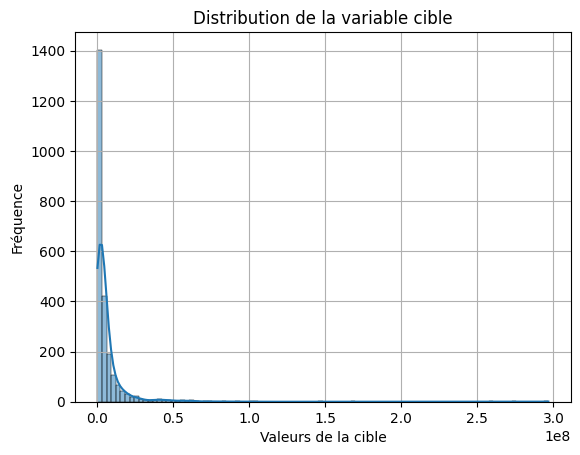

In [583]:
sns.histplot(building_consumption_pour_analyses['SiteEnergyUseWN(kBtu)'].dropna(), kde=True)
plt.title("Distribution de la variable cible")
plt.xlabel("Valeurs de la cible")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

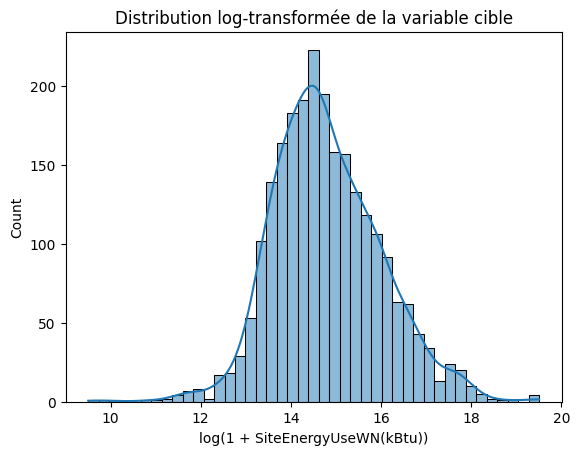

In [584]:
sns.histplot(np.log1p(building_consumption_pour_analyses['SiteEnergyUseWN(kBtu)'].dropna()), kde=True)
plt.title("Distribution log-transformée de la variable cible")
plt.xlabel("log(1 + SiteEnergyUseWN(kBtu))")
plt.show()

In [585]:
ordre_annee = ['1900-1974', '1975–1999', 'IECC 2000–2018']
ordre_nb_etages = ['Bas', 'Moyen', 'Haut']
ordre_nb_batiments = ['Bat_unique', 'Bat_multiple']  

building_consumption_pour_analyses['Groupe_anne_construction'] = pd.Categorical(
    building_consumption_pour_analyses['Groupe_anne_construction'],
    categories=ordre_annee, ordered=True
)
building_consumption_pour_analyses['Groupe_nb_etages'] = pd.Categorical(
    building_consumption_pour_analyses['Groupe_nb_etages'],
    categories=ordre_nb_etages, ordered=True
)
building_consumption_pour_analyses['Groupe_nb_batiments'] = pd.Categorical(
    building_consumption_pour_analyses['Groupe_nb_batiments'],
    categories=ordre_nb_batiments, ordered=True
)

# Encodage ordinal (0..k-1 ; -1 si hors catégories)
building_consumption_pour_analyses['Groupe_anne_construction_label'] = (
    building_consumption_pour_analyses['Groupe_anne_construction'].cat.codes
)
building_consumption_pour_analyses['Groupe_nb_etages_label'] = (
    building_consumption_pour_analyses['Groupe_nb_etages'].cat.codes
)
building_consumption_pour_analyses['Groupe_nb_batiments_label'] = (
    building_consumption_pour_analyses['Groupe_nb_batiments'].cat.codes
)

building_consumption_pour_analyses["SiteEnergyUseWN(kBtu)_ajuste"] = building_consumption_pour_analyses["SiteEnergyUseWN(kBtu)"]*building_consumption_pour_analyses["PartNonHabitation(%)"]/100

# Suppression des dernières lignes devenu inutiles après manipulations

del building_consumption_pour_analyses["Groupe_anne_construction"]
del building_consumption_pour_analyses["Groupe_nb_etages"]
del building_consumption_pour_analyses["Groupe_nb_batiments"]
del building_consumption_pour_analyses["SiteEnergyUseWN(kBtu)"]
del building_consumption_pour_analyses["PartHabitation(%)"]
del building_consumption_pour_analyses["PartNonHabitation(%)"]


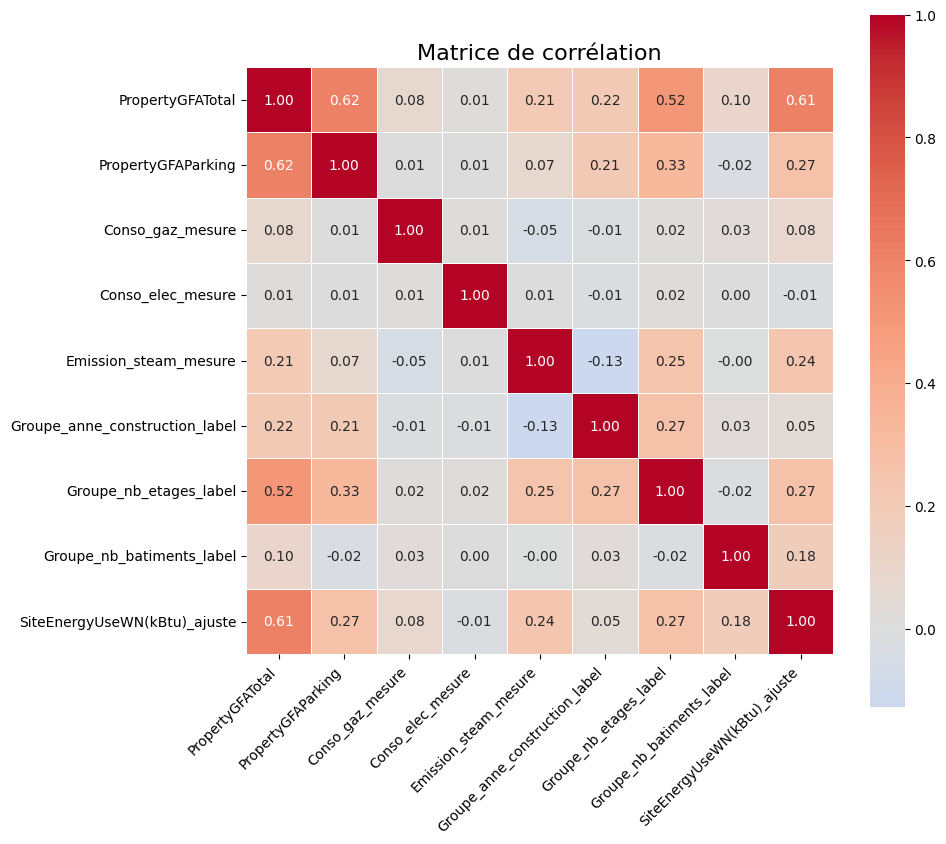

In [586]:
matrice_correlation_pearson = (
    building_consumption_pour_analyses.corr(method='pearson', numeric_only=True)
)

plt.figure(figsize=(10, 10))

sns.heatmap(
    matrice_correlation_pearson,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title(
    "Matrice de corrélation",
    fontsize=16
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [587]:
#One hot encoding sur les variables d'interêts

building_consumption_pour_analyses = pd.get_dummies(
    building_consumption_pour_analyses, 
    columns=["BuildingType"], 
    drop_first=False  
)

In [588]:
building_consumption_pour_analyses = pd.get_dummies(
    building_consumption_pour_analyses, 
    columns=["CouncilDistrictCode"], 
    drop_first=False  
)

In [589]:
building_consumption_pour_analyses = pd.get_dummies(
    building_consumption_pour_analyses, 
    columns=["Usage_multiple"], 
    drop_first=False  
)

building_consumption_pour_analyses.head()

,PropertyGFATotal,PropertyGFAParking,Conso_gaz_mesure,Conso_elec_mesure,Emission_steam_mesure,Groupe_anne_construction_label,Groupe_nb_etages_label,Groupe_nb_batiments_label,SiteEnergyUseWN(kBtu)_ajuste,BuildingType_Multifamily HR (10+),...,BuildingType_SPS-District K-12,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Usage_multiple_Mono usage,Usage_multiple_Multi usage
0,88434,0,1,1,1,0,2,0,7456910.0,False,...,False,False,False,False,False,False,False,True,True,False
1,103566,15064,1,1,0,1,2,0,8664479.0,False,...,False,False,False,False,False,False,False,True,False,True
2,956110,196718,1,1,1,0,2,0,73937112.0,False,...,False,False,False,False,False,False,False,True,True,False
3,61320,0,1,1,1,0,2,0,6946800.5,False,...,False,False,False,False,False,False,False,True,True,False
4,175580,62000,1,1,0,1,2,0,14656503.0,False,...,False,False,False,False,False,False,False,True,False,True


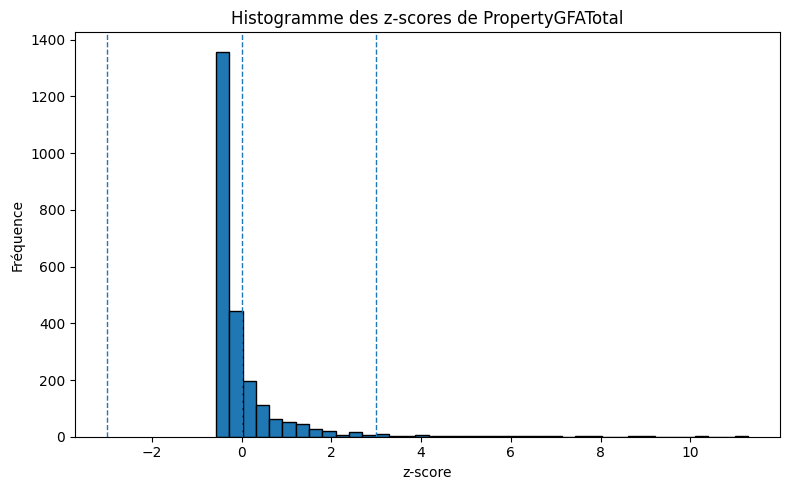

In [590]:
building_consumption_pour_analyses['z_GFAtotal'] = stats.zscore(building_consumption_pour_analyses.PropertyGFATotal)

plt.figure(figsize=(8, 5))
plt.hist(building_consumption_pour_analyses['z_GFAtotal'], bins=40, edgecolor='black')
plt.axvline(0, linestyle='--', linewidth=1)      # moyenne
plt.axvline( 3, linestyle='--', linewidth=1)     # seuil outliers typique
plt.axvline(-3, linestyle='--', linewidth=1)
plt.title("Histogramme des z-scores de PropertyGFATotal")
plt.xlabel("z-score")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

In [591]:
building_consumption_pour_analyses = building_consumption_pour_analyses.loc[building_consumption_pour_analyses['z_GFAtotal']<3,:]

building_consumption_pour_analyses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2342 entries, 0 to 3375
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PropertyGFATotal                   2342 non-null   int64  
 1   PropertyGFAParking                 2342 non-null   int64  
 2   Conso_gaz_mesure                   2342 non-null   int64  
 3   Conso_elec_mesure                  2342 non-null   int64  
 4   Emission_steam_mesure              2342 non-null   int64  
 5   Groupe_anne_construction_label     2342 non-null   int8   
 6   Groupe_nb_etages_label             2342 non-null   int8   
 7   Groupe_nb_batiments_label          2342 non-null   int8   
 8   SiteEnergyUseWN(kBtu)_ajuste       2342 non-null   float64
 9   BuildingType_Multifamily HR (10+)  2342 non-null   bool   
 10  BuildingType_Multifamily LR (1-4)  2342 non-null   bool   
 11  BuildingType_Multifamily MR (5-9)  2342 non-null   bool   
 1

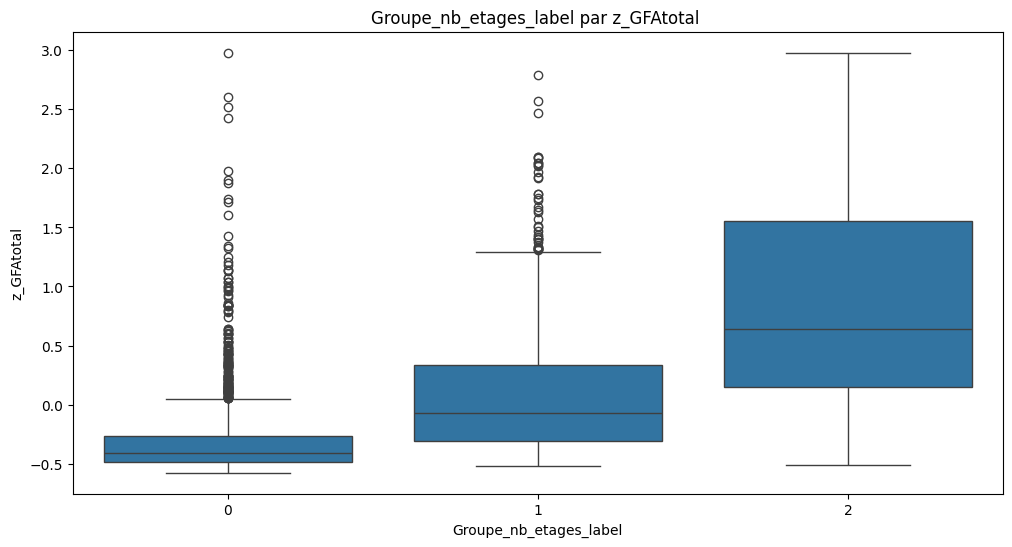

In [592]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=building_consumption_pour_analyses, x="Groupe_nb_etages_label", y="z_GFAtotal")
plt.title("Groupe_nb_etages_label par z_GFAtotal ")
plt.ylabel("z_GFAtotal")
plt.show()

In [593]:
del building_consumption_pour_analyses["z_GFAtotal"]

building_consumption_pour_analyses_scale = building_consumption_pour_analyses.copy()

scaler = StandardScaler()

#building_consumption_pour_analyses_scale['SiteEnergyUseWN(kBtu)_ajuste'] = scaler.fit_transform(building_consumption_pour_analyses_scale["SiteEnergyUseWN(kBtu)_ajuste"].values.reshape(-1, 1))
#building_consumption_pour_analyses_scale['PropertyGFATotal'] = scaler.fit_transform(building_consumption_pour_analyses_scale["PropertyGFATotal"].values.reshape(-1, 1))
#building_consumption_pour_analyses_scale['PropertyGFAParking'] = scaler.fit_transform(building_consumption_pour_analyses_scale["PropertyGFAParking"].values.reshape(-1, 1))

building_consumption_pour_analyses_scale["SiteEnergyUseWN(kBtu)_ajuste"] = np.log1p(
    building_consumption_pour_analyses_scale["SiteEnergyUseWN(kBtu)_ajuste"]
)

building_consumption_pour_analyses_scale["PropertyGFATotal"] = np.log1p(
    building_consumption_pour_analyses_scale["PropertyGFATotal"]
)

building_consumption_pour_analyses_scale["PropertyGFAParking"] = np.log1p(
    building_consumption_pour_analyses_scale["PropertyGFAParking"]
)

In [594]:
building_consumption_pour_analyses_scale.head()

,PropertyGFATotal,PropertyGFAParking,Conso_gaz_mesure,Conso_elec_mesure,Emission_steam_mesure,Groupe_anne_construction_label,Groupe_nb_etages_label,Groupe_nb_batiments_label,SiteEnergyUseWN(kBtu)_ajuste,BuildingType_Multifamily HR (10+),...,BuildingType_SPS-District K-12,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7,Usage_multiple_Mono usage,Usage_multiple_Multi usage
0,11.390023,0.000000,1,1,1,0,2,0,15.824652,False,...,False,False,False,False,False,False,False,True,True,False
1,11.547974,9.620129,1,1,0,1,2,0,15.974742,False,...,False,False,False,False,False,False,False,True,False,True
3,11.023878,0.000000,1,1,1,0,2,0,15.753792,False,...,False,False,False,False,False,False,False,True,True,False
4,12.075856,11.034906,1,1,0,1,2,0,16.500395,False,...,False,False,False,False,False,False,False,True,False,True
5,11.485441,10.524037,1,1,0,1,0,0,16.347755,False,...,False,False,False,False,False,False,False,True,True,False


# Extraction du fichier CSV nettoyé pour l'analyse

In [595]:
building_consumption_pour_analyses_scale.to_csv("building_consumption_pour_analyses.csv", index=False, encoding="utf-8")